<h1>Amazon Food Fine Reviews </h1>


Tasks
1. EDA ( Exploratory Data Analysis)
2. Build Bag of Words
3. Use a Naive Bayes sklearn function and find out the sentiment of a review
4. 
a. Use Logistic Regression sklearn function to classify the statements into +ve and -ve statements
b. Do the step 4a with the use of L1 and L2 regularisers and do the grid search on λ
5. 
a. Use linear SVM to classify the review into +ve and -ve review ( use the grid search engine on C)
b. Use the RBF kernel with SVM and predict the sentiment of a review. ( use the grid search engine on λ and C)


In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.cross_validation import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model

con = sqlite3.connect('database.sqlite')
pd.read_sql_query("SELECT * FROM Reviews LIMIT 3", con)

C:\Users\This PC\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


# Exploratory Data Analysis

In [2]:
food_reviews = pd.read_sql_query("SELECT * FROM Reviews ", con)
print food_reviews.head()

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [3]:
print food_reviews.shape

(568454, 10)


In [3]:
# Now Selecting Data Feature That from the Given data
features  = pd.read_sql_query("SELECT HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text FROM Reviews ", con)
print features.head()

   HelpfulnessNumerator  HelpfulnessDenominator  Score                Summary  \
0                     1                       1      5  Good Quality Dog Food   
1                     0                       0      1      Not as Advertised   
2                     1                       1      4  "Delight" says it all   
3                     3                       3      2         Cough Medicine   
4                     0                       0      5            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


In [4]:
print features.shape

(568454, 5)


In [5]:
print features.count()

HelpfulnessNumerator      568454
HelpfulnessDenominator    568454
Score                     568454
Summary                   568454
Text                      568454
dtype: int64


In [6]:
print type(features['Score'])

<class 'pandas.core.series.Series'>


In [4]:
scores = features['Score']
# Here we are considering Score less than three as 0 and score more than three as 1..
features['Score']=features['Score'].apply(lambda x : 1 if x > 3 else 0)
print features.head()

   HelpfulnessNumerator  HelpfulnessDenominator  Score                Summary  \
0                     1                       1      1  Good Quality Dog Food   
1                     0                       0      0      Not as Advertised   
2                     1                       1      1  "Delight" says it all   
3                     3                       3      0         Cough Medicine   
4                     0                       0      1            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


In [8]:
features.groupby('Score')['Summary'].count()

Score
0    124677
1    443777
Name: Summary, dtype: int64

In [9]:
# Calculating the percentage of Negative and Positive Reviews 
print ('Percentage of negative reviews %.2f %%' % ((features.groupby('Score')['Summary'].count()[0])*100.0/len(features)))
print ('Percentage of positive reviews %.2f %%' % ((features.groupby('Score')['Summary'].count()[1])*100.0/len(features)))

Percentage of negative reviews 21.93 %
Percentage of positive reviews 78.07 %


## Positive Reviews are more Common

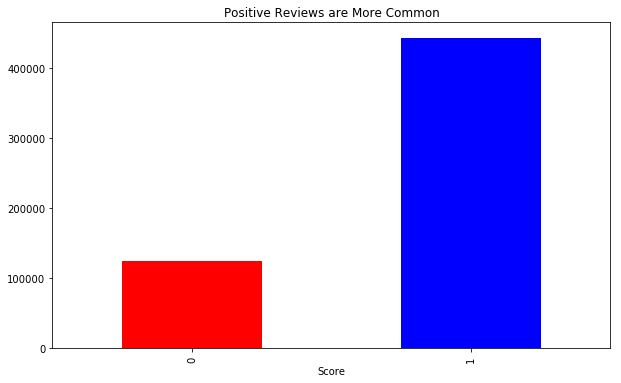

In [5]:
features.groupby('Score')['Summary'].count().plot(kind='bar',color=['r','b'],title='Positive Reviews are More Common',figsize=(10,6))

## Positive Reviews are Shorter

In [6]:
# Adding new column "length" which keeps the length of the text given as a review of product given by Customers
features['Length'] = features.Text.str.len()
print features.head()

   HelpfulnessNumerator  HelpfulnessDenominator  Score                Summary  \
0                     1                       1      1  Good Quality Dog Food   
1                     0                       0      0      Not as Advertised   
2                     1                       1      1  "Delight" says it all   
3                     3                       3      0         Cough Medicine   
4                     0                       0      1            Great taffy   

                                                Text  Length  
0  I have bought several of the Vitality canned d...     263  
1  Product arrived labeled as Jumbo Salted Peanut...     190  
2  This is a confection that has been around a fe...     509  
3  If you are looking for the secret ingredient i...     219  
4  Great taffy at a great price.  There was a wid...     140  


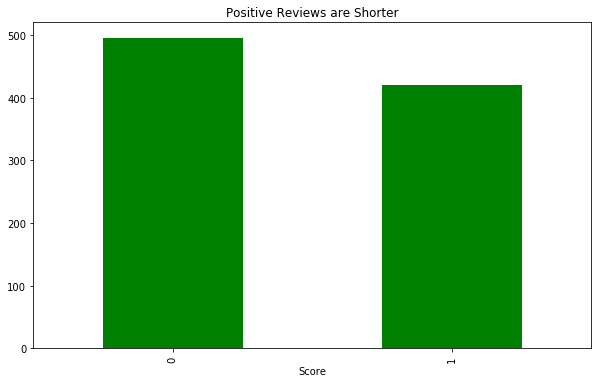

In [7]:
# Plotting Graph to show that positive Reviews
features.groupby('Score')['Length'].mean().plot(kind='bar',color=['g','g'],title='Positive Reviews are Shorter',figsize=(10,6))   

## Longer Reviews are more helpful

In [8]:
# Adding new Coloumn Usefullness 
features['Usefullness'] = features['HelpfulnessNumerator']/features['HelpfulnessDenominator']
print features.head()

   HelpfulnessNumerator  HelpfulnessDenominator  Score                Summary  \
0                     1                       1      1  Good Quality Dog Food   
1                     0                       0      0      Not as Advertised   
2                     1                       1      1  "Delight" says it all   
3                     3                       3      0         Cough Medicine   
4                     0                       0      1            Great taffy   

                                                Text  Length  Usefullness  
0  I have bought several of the Vitality canned d...     263          1.0  
1  Product arrived labeled as Jumbo Salted Peanut...     190          NaN  
2  This is a confection that has been around a fe...     509          1.0  
3  If you are looking for the secret ingredient i...     219          1.0  
4  Great taffy at a great price.  There was a wid...     140          NaN  


In [9]:
features['Usefullness'] = features['Usefullness'].apply(lambda x : 1 if (x >= 0.250000) else 0 )
print features.head()

   HelpfulnessNumerator  HelpfulnessDenominator  Score                Summary  \
0                     1                       1      1  Good Quality Dog Food   
1                     0                       0      0      Not as Advertised   
2                     1                       1      1  "Delight" says it all   
3                     3                       3      0         Cough Medicine   
4                     0                       0      1            Great taffy   

                                                Text  Length  Usefullness  
0  I have bought several of the Vitality canned d...     263            1  
1  Product arrived labeled as Jumbo Salted Peanut...     190            0  
2  This is a confection that has been around a fe...     509            1  
3  If you are looking for the secret ingredient i...     219            1  
4  Great taffy at a great price.  There was a wid...     140            0  


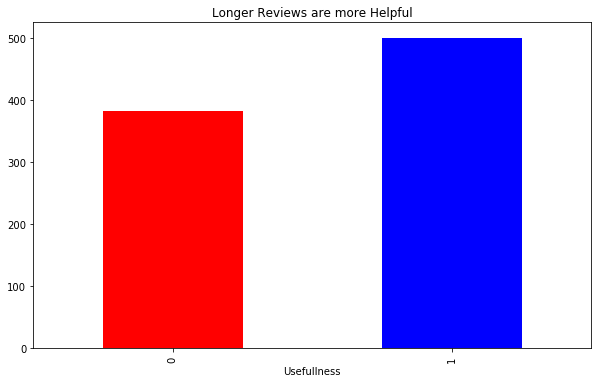

In [10]:
features.groupby('Usefullness')['Length'].mean().plot(kind='bar',color=['r','b'],title='Longer Reviews are more Helpful',figsize=(10,6))   

## Despite being more common and shorter, positive reviews are found more helpful

In [11]:
x=features['Score']
y=features['Usefullness']
z=np.empty(len(features['Score']))
for i in range(len(features['Score'])) : 
    if(x[i]==1 and y[i]==1):
        z[i]=1
    else :
        z[i]=0
features['helpful']=z
print features['helpful'].head()

0    1.0
1    0.0
2    1.0
3    0.0
4    0.0
Name: helpful, dtype: float64


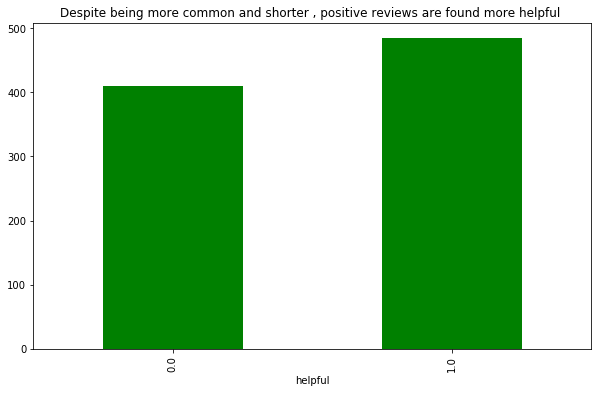

In [12]:
features.groupby('helpful')['Length'].mean().plot(kind='bar',color=['g','g'],title='Despite being more common and shorter , positive reviews are found more helpful ',figsize=(10,6))   

## Split the data into two parts (Test and train data sets).

In [13]:
# reviews = features['Score','Summary','Text']
reviews = features.filter(['Score','Summary','Text'], axis = 1)
print reviews.head()

   Score                Summary  \
0      1  Good Quality Dog Food   
1      0      Not as Advertised   
2      1  "Delight" says it all   
3      0         Cough Medicine   
4      1            Great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


### Remove all special characters, html tags,stopwords , stemming and converting Capital to small letters from both text fields(Summary and Text)

In [23]:
import re
import string
from bs4 import BeautifulSoup 
import nltk
#nltk.download()
from nltk.corpus import stopwords
stops = stopwords.words("english")
print stops

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [14]:
import re
import string
import nltk

cleanup_re = re.compile('[^a-z]+')
def cleanup(sentence):
    sentence = sentence.encode('utf-8')
    sentence = sentence.lower()
    sentence = cleanup_re.sub(' ', sentence).strip()
    #sentence = [w for w in sentence if not w in stops]
    #sentence = " ".join(nltk.word_tokenize(sentence))
    return sentence

reviews["Summary"] = reviews["Summary"].apply(cleanup)
print reviews.head()

   Score                Summary  \
0      1  good quality dog food   
1      0      not as advertised   
2      1    delight says it all   
3      0         cough medicine   
4      1            great taffy   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  
2  This is a confection that has been around a fe...  
3  If you are looking for the secret ingredient i...  
4  Great taffy at a great price.  There was a wid...  


In [15]:
reviews["Text"] = reviews["Text"].apply(cleanup)
print reviews.head()

   Score                Summary  \
0      1  good quality dog food   
1      0      not as advertised   
2      1    delight says it all   
3      0         cough medicine   
4      1            great taffy   

                                                Text  
0  i have bought several of the vitality canned d...  
1  product arrived labeled as jumbo salted peanut...  
2  this is a confection that has been around a fe...  
3  if you are looking for the secret ingredient i...  
4  great taffy at a great price there was a wide ...  


In [22]:
# Getting this not so meaning ful data after applying stemming and stopwords
#reviews["Text"] = reviews["Text"].apply(cleanup)
#print reviews.head()

   Score    Summary                                               Text
0      1  g qul g f   hve bugh everl f he vl cnne g f pruc n hve fu...
1      0    n  vere  pruc rrve lbele  jub le penu he penu were cull...
2      1  elgh   ll  h   cnfecn h h been run  few cenure    lgh pll...
3      0  cugh ecne  f u re lkng fr he ecre ngreen n rbun  beleve  ...
4      1     gre ff  gre ff   gre prce here w  we ren f u ff elver ...


## Split the data into two parts (Test and train data sets).

In [16]:
train, test = train_test_split(reviews, test_size=0.3)
print("%d items in training data, %d in test data" % (len(train), len(test)))

397917 items in training data, 170537 in test data


In [17]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train["Summary"])

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_new_counts = count_vect.transform(test["Summary"])
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

y_train = train["Score"]
y_test = test["Score"]

prediction = dict()

In [19]:
# value in test and train data
print X_test_tfidf.shape , X_train_tfidf.shape

(170537, 28036) (397917, 28036)


In [64]:
print X_train_tfidf


  (0, 8562)	0.774603538703
  (0, 6919)	0.632447118602
  (1, 18159)	0.712762199152
  (1, 4387)	0.701405765203
  (2, 3470)	0.291065020285
  (2, 17251)	0.43992509219
  (2, 1594)	0.369051121946
  (2, 27289)	0.354501604233
  (2, 6636)	0.646972334886
  (2, 12652)	0.203233233274
  (3, 9181)	0.734002469748
  (3, 825)	0.298798709498
  (3, 4057)	0.609884993755
  (4, 16737)	0.40696238864
  (4, 10411)	0.361360127615
  (4, 1305)	0.590851052325
  (4, 585)	0.595563184196
  (5, 4060)	0.479459278871
  (5, 24734)	0.357228146191
  (5, 10370)	0.538622570697
  (5, 25086)	0.280597453975
  (5, 24754)	0.220701927868
  (5, 23554)	0.474287155283
  (6, 24754)	0.416007854778
  (6, 2147)	0.470908369527
  :	:
  (397911, 11228)	0.630787128927
  (397912, 10674)	0.387618137842
  (397912, 7158)	0.592114066809
  (397912, 25423)	0.706507686514
  (397913, 24125)	0.427723563772
  (397913, 25193)	0.662985792242
  (397913, 21290)	0.614412233179
  (397914, 6424)	0.273593017275
  (397914, 18391)	0.448012230143
  (397914, 8258)

## Implementing Bag of Words

In [20]:
vectorizer = CountVectorizer()
train_data_features = vectorizer.fit_transform(reviews['Summary'])
#train_data_features = train_data_features.toarray()
vocab = vectorizer.get_feature_names()
print vocab 
print train_data_features.shape

[u'aa', u'aaa', u'aaaa', u'aaaaa', u'aaaaaaaaaaaa', u'aaaaaaaaaaacccckkkkk', u'aaaaaaaaaaahhhhhhhhhhhhh', u'aaaaaaaah', u'aaaaaaggggggghhhhhhhh', u'aaaaaagggghhhh', u'aaaaaagh', u'aaaaaamazing', u'aaaaahhh', u'aaaah', u'aaaahhh', u'aaaahhhh', u'aaaahhhhh', u'aaaamaaaazing', u'aaaamazing', u'aaaammmmaaaaazziiiinnnnggg', u'aaaarrrrrgggghhhhh', u'aaaccchhh', u'aaah', u'aaahhh', u'aaahhhh', u'aaahhhhhh', u'aaamazing', u'aachener', u'aack', u'aacute', u'aah', u'aahey', u'aahh', u'aamzing', u'aardvark', u'aat', u'aaverage', u'aawesome', u'ab', u'aback', u'abacore', u'abalone', u'abaloo', u'abandon', u'abandons', u'abb', u'abba', u'abbey', u'abbie', u'abbott', u'abby', u'abc', u'abctoy', u'abd', u'abdominal', u'abel', u'abfab', u'abhor', u'abi', u'abide', u'ability', u'abit', u'abj', u'abject', u'able', u'aboard', u'abolt', u'abolutely', u'abomination', u'abominations', u'aborio', u'aboslutely', u'abosolutely', u'abot', u'abound', u'abounds', u'about', u'above', u'abra', u'abroad', u'absence'

In [21]:
dist = np.sum(train_data_features , axis = 0)

for tag , count in zip (vocab , dist) :
    print count , tag

[[21  7  3 ...,  1  5  1]] aa


In [22]:
reviews.head()

,Score,Summary,Text
0,1,good quality dog food,i have bought several of the vitality canned d...
1,0,not as advertised,product arrived labeled as jumbo salted peanut...
2,1,delight says it all,this is a confection that has been around a fe...
3,0,cough medicine,if you are looking for the secret ingredient i...
4,1,great taffy,great taffy at a great price there was a wide ...


# Implementation of Naive Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB
model = MultinomialNB().fit(X_train_tfidf, y_train)
prediction['Multinomial'] = model.predict(X_test_tfidf)

In [25]:
print(metrics.classification_report(y_test, prediction['Multinomial'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.83      0.51      0.63     37292
   negative       0.88      0.97      0.92    133245

avg / total       0.87      0.87      0.86    170537



## Implementation of Bernoulli Naive Bayes

In [26]:
from sklearn.naive_bayes import BernoulliNB
model = BernoulliNB().fit(X_train_tfidf, y_train)
prediction['Bernoulli'] = model.predict(X_test_tfidf)

In [27]:
print(metrics.classification_report(y_test, prediction['Bernoulli'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.73      0.67      0.70     37292
   negative       0.91      0.93      0.92    133245

avg / total       0.87      0.87      0.87    170537



## Logistic Regression

In [28]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=1e5)
logreg_result = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

In [29]:
print(metrics.classification_report(y_test, prediction['Logistic'], target_names = ["positive", "negative"]))

             precision    recall  f1-score   support

   positive       0.79      0.69      0.74     37292
   negative       0.92      0.95      0.93    133245

avg / total       0.89      0.89      0.89    170537



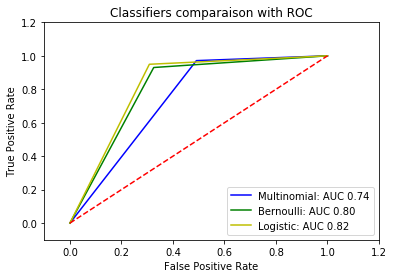

In [31]:
def formatt(x):
    if x == 0:
        return 0
    return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, predicted in prediction.items():
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test.map(formatt), vfunc(predicted))
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.plot(false_positive_rate, true_positive_rate, colors[cmp], label='%s: AUC %0.2f'% (model,roc_auc))
    cmp += 1

plt.title('Classifiers comparaison with ROC')
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

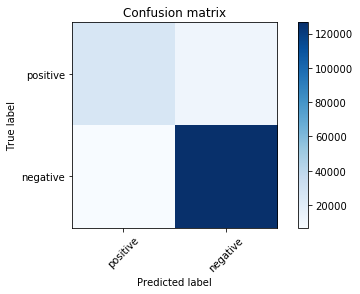

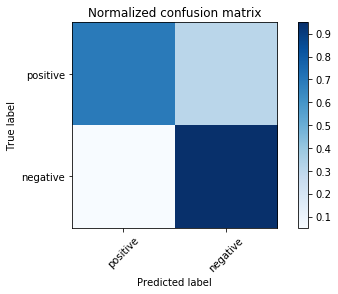

In [32]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=["positive", "negative"]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cm = confusion_matrix(y_test, prediction['Logistic'])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cm)    

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()
print cm

## Grid Search Cross Validate with l2 regularizer

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [34]:
reviews['smry_txt'] = reviews['Summary'].astype(str) + ' ' + reviews['Text']
#dataset = reviews.loc[reviews['Score'] != 3][['smry_txt','Score']]
#reviews = features.filter(['Score','Summary','Text'], axis = 1)
dataset = reviews.filter(['Score','smry_txt'],axis = 1)
print dataset.head()

   Score                                           smry_txt
0      1  good quality dog food i have bought several of...
1      0  not as advertised product arrived labeled as j...
2      1  delight says it all this is a confection that ...
3      0  cough medicine if you are looking for the secr...
4      1  great taffy great taffy at a great price there...


In [60]:
count_vec_total = CountVectorizer()

x_data = count_vec_total.fit_transform(reviews.smry_txt)
y_data = reviews['Score']


print(reviews.iloc[0]['smry_txt'])
print(count_vec_total.inverse_transform(x_data[0]))
print(x_data[0])

good quality dog food i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most
[array([u'most', u'this', u'appreciates', u'she', u'finicky', u'is',
       u'labrador', u'my', u'better', u'smells', u'it', u'meat',
       u'processed', u'than', u'stew', u'like', u'more', u'looks',
       u'product', u'be', u'to', u'all', u'them', u'found', u'and',
       u'products', u'canned', u'vitality', u'the', u'of', u'several',
       u'bought', u'have', u'food', u'dog', u'quality', u'good'], 
      dtype='<U105')]
  (0, 66535)	1
  (0, 103226)	1
  (0, 4796)	1
  (0, 91856)	1
  (0, 37701)	1
  (0, 53018)	1
  (0, 57135)	1
  (0, 67570)	1
  (0, 9371)	2
  (0, 94193)	1
  (0, 53176)	1
  (0, 63270)	1
  (0, 80300)	1
  (0, 102736)	2
  (0, 97700)	1
  (0, 58835)	1
  (0, 66352)	1
  (0, 59936)	1
  (0, 80394)	2
  (0

In [35]:
#   GridsearchCV will build classifier specified (logistic regression),
# with the optimal C value, with 3-fold cross validation by defalut. 
# So, we don't need to build a classifier again with this model..
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
log_reg_l2 = LogisticRegression(penalty='l2')
log_reg_l2_grid_clf = GridSearchCV(log_reg_l2, param_grid=param_grid,n_jobs=-1, verbose=40)
log_reg_l2_grid_clf

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=40)

In [40]:
print y_test.shape

(170537L,)


In [37]:
from datetime import datetime
startTime = datetime.now()

#lets run GridsearchCV on our data
log_reg_l2_grid_clf.fit(X_train_tfidf, y_train)

print(datetime.now() - startTime)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.9min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  3.0min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.0min remaining:   45.1s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  3.1min remaining:   28.7s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.2min remaining:    0.0s
[Parallel(n_jobs=-

0:03:31.163000


In [38]:
log_reg_l2_grid_clf.best_params_ ,log_reg_l2_grid_clf.best_estimator_, log_reg_l2_grid_clf.best_score_

({'C': 10},
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 0.89368637178104982)

In [66]:
y_true, y_pred = y_test , log_reg_l2_grid_clf.predict(X_test_tfidf)

print y_true

167642    1
197632    0
143417    1
259780    1
221918    1
540686    1
386168    1
436003    0
395839    1
216537    1
500907    1
419704    1
136828    0
26390     0
241747    0
258814    0
205006    1
363524    1
245516    1
397070    1
351934    1
6793      1
37234     1
1532      1
450372    1
42928     1
543841    1
414208    0
112103    0
342149    1
         ..
151786    0
197100    1
333746    1
79182     1
547757    1
128290    1
213798    1
432820    1
259664    0
117292    0
502668    0
360062    1
425282    1
446341    1
379467    1
411395    1
493836    0
552702    1
266754    1
536619    1
394426    1
337870    1
389302    1
410592    1
199548    1
545580    1
261624    1
518943    1
562670    0
354918    0
Name: Score, Length: 170537, dtype: int64


In [67]:
print y_pred

[1 0 1 ..., 1 0 0]


In [44]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

print(classification_report(y_true, y_pred))
print(precision_recall_fscore_support(y_test, y_pred, average='micro'))
print y_pred

             precision    recall  f1-score   support

          0       0.81      0.69      0.74     37292
          1       0.92      0.95      0.93    133245

avg / total       0.89      0.90      0.89    170537

(0.89586424060467817, 0.89586424060467817, 0.89586424060467817, None)
[1 0 1 ..., 1 0 0]


In [47]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, threshold = roc_curve(y_test, y_pred)
print("FPR: {}, \nTPR: {}, \nAUC : {}".format(fpr[1], tpr[1], auc(fpr,tpr)))

FPR: 0.310897779685, 
TPR: 0.953731847349, 
AUC : 0.821417033832


## Grid Search Cross Validate using L1 Regularizer

In [48]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
log_reg_l1 = LogisticRegression(penalty='l1')
log_reg_l1_grid_clf = GridSearchCV(log_reg_l1, param_grid=param_grid,n_jobs=-1, verbose=40)
log_reg_l1_grid_clf

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=40)

In [49]:
from datetime import datetime
startTime = datetime.now()

#lets run GridsearchCV on our data
log_reg_l1_grid_clf.fit(X_train_tfidf, y_train)

print(datetime.now() - startTime)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  2.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  2.2min remaining:   48.4s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.3min remaining:   33.8s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  2.5min remaining:   23.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-

0:02:52.409000


In [50]:
log_reg_l1_grid_clf.best_params_ ,log_reg_l1_grid_clf.best_estimator_, log_reg_l1_grid_clf.best_score_

({'C': 10},
 LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 0.89267108467343692)

In [51]:
y_true, y_pred = y_test, log_reg_l1_grid_clf.predict(X_test_tfidf)

In [53]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.80      0.69      0.74     37292
          1       0.92      0.95      0.93    133245

avg / total       0.89      0.90      0.89    170537



In [54]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, threshold = roc_curve(y_true, y_pred)
print("FPR: {}, \nTPR: {}, \nAUC : {}".format(fpr[1], tpr[1], auc(fpr,tpr)))

FPR: 0.309717901963, 
TPR: 0.952410972269, 
AUC : 0.821346535153


# SVM

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

In [74]:
param_grid = {'C':[0.03125, 0.125, 0.5, 2, 8]}
lr_svm = LinearSVC(verbose=20, max_iter = 100000)
lr_svm_grid_cv = GridSearchCV(lr_svm, param_grid=param_grid, n_jobs=-1, verbose=20)
lr_svm_grid_cv


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=100000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=20),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.03125, 0.125, 0.5, 2, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=20)

In [75]:
from datetime import datetime
start_time = datetime.now()

#perform grid search for c
lr_svm_grid_cv.fit(X_train_tfidf, y_train)

print(datetime.now() - start_time)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   9 out of  15 | elapsed:  3.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  3.3min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  11 out of  15 | elapsed:  3.3min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  3.5min remaining:   52.4s
[Parallel(n_jobs=-1)]: Done  13 out of  15 | elapsed:  4.0min remaining:   37.1s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-

[LibLinear]0:05:36.212000


In [77]:
y_true, y_pred = y_test, lr_svm_grid_cv.predict(X_test_tfidf)

In [78]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(y_true, y_pred))
print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

             precision    recall  f1-score   support

          0       0.82      0.68      0.74     37292
          1       0.91      0.96      0.93    133245

avg / total       0.89      0.90      0.89    170537

(0.89564727888962514, 0.89564727888962514, 0.89564727888962514, None)


In [79]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

#y_pred = np.where(y_pred == 'positive', 1, 0)
#y_true = np.where(y_true == 'positive', 1, 0)

fpr, tpr, threshold = roc_curve(y_true, y_pred)
print("FPR: {}, \nTPR: {}, \nAUC : {}".format(fpr[1], tpr[1], auc(fpr,tpr)))

FPR: 0.323849619221, 
TPR: 0.95707906488, 
AUC : 0.81661472283


# SVM-RBF Kernal

In [80]:
from sklearn.svm import SVC

In [81]:
param_grid = {'C':[0.03125, 0.125, 0.5, 2, 8],
             'gamma': [3.0517578125e-05, 0.00048828125, 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid_cv = GridSearchCV(rbf_svm, param_grid=param_grid, n_jobs=-1, verbose=30)
rbf_svm_grid_cv

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': [0.03125, 0.125, 0.5, 2, 8], 'gamma': [3.0517578125e-05, 0.00048828125, 0.0078125, 0.125, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=30)

In [ ]:
from datetime import datetime
start_time = datetime.now()

#perform gridsearch
rbf_svm_grid_cv.fit(X_train_tfidf, y_train)

print(datetime.now() - start_time)


In [ ]:
rbf_svm_grid_cv.best_params_, rbf_svm_grid_cv.best_estimator_, rbf_svm_grid_cv.best_score_

In [ ]:
y_true, y_pred = y_test, rbf_svm_grid_cv.predict(x_test)